In [1]:
%cd ../

/home/babycar/RecSysMDP


In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from constructors.mdp_constructor import load_data, make_mdp
from constructors.algorithm_constuctor import init_algo,init_model
from recsys_mdp.mdp_former.utils import to_d3rlpy_form_ND

In [3]:
model_name = "cgxdoalsaq"
with open(f"./config/{model_name}/cfg.yaml") as f:
        config = yaml.load(f)

/tmp/ipykernel_2752812/940906565.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [4]:
prediction_type = True if config['experiment']['scorer']['prediction_type'] == "discrete" else False

# Load train data
data, data_mapping, train_values = load_data(data_path=config['experiment']['data_path'],
                                             return_values=True,
                                             col_mapping=config['experiment']['col_mapping'])
mdp_preparator = make_mdp(data=data, data_mapping=data_mapping, **config['experiment']['mdp_settings'])
states, rewards, actions, termations, state_tail = mdp_preparator.create_mdp()
train_mdp = to_d3rlpy_form_ND(states, rewards, actions, termations, discrete=prediction_type)

In [5]:
train_mdp.observations

array([[ 157., 2900., 2804., 2900.,   74.,   11.],
       [2900., 2804., 2900.,   74.,   74.,   11.],
       [2804., 2900.,   74.,   74., 3438.,   11.],
       ...,
       [1698., 2642., 1909., 2615., 2306., 2896.],
       [2642., 1909., 2615., 2306.,  543., 2896.],
       [1909., 2615., 2306.,  543.,  805., 2896.]], dtype=float32)

In [6]:
#config['experiment']['algo_settings']['model_parametrs']['freeze_emb'] = 0
# config['experiment']['algo_settings']['model_parametrs']['state_repr_name'] = 'drr'
# config['experiment']['algo_settings']['use_als'] = 0
    
model = init_model(train_values, **config['experiment']['algo_settings']['model_parametrs'])

    
algo = init_algo(model, **config['experiment']['algo_settings']['general_parametrs'])

In [7]:
algo

d3rlpy.algos.bc.DiscreteBC(action_scaler=None, batch_size=1024, beta=0.5, encoder_factory=d3rlpy.models.encoders.DefaultEncoderFactory(activation='relu', use_batch_norm=False, dropout_rate=None), gamma=1.0, generated_maxlen=100000, impl=None, learning_rate=0.001, n_frames=1, n_steps=1, optim_factory=d3rlpy.models.optimizers.AdamFactory(optim_cls='Adam', betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), real_ratio=1.0, reward_scaler=None, scaler=None, use_gpu=None)

In [68]:
algo.build_with_dataset(train_mdp)

2023-05-04 13:59.00 [warning  ] Parameters will be reinitialized.


In [69]:
algo.load_model(f'pretrained_models/{model_name}.pt')

In [70]:
def calc_distrib(mdp):
    users = dict()
    users_original = dict()
    for episode in mdp:
        user = episode.observations[0][-1]
        preds = algo.predict(episode.observations)
      #  print(preds)
        if user not in users.keys():
            users[user] = preds.tolist()
            users_original[user] = episode.actions.tolist()
        else:
            users[user]+=(preds.tolist())
            users_original[user] += episode.actions.tolist()
    return users, users_original


In [71]:
users = dict()
users_original = dict()
episode = train_mdp[-45]
user = episode.observations[0][-1]

In [72]:
algo.impl._imitator(obs)

tensor([[-7.4151, -7.3954, -8.9302,  ..., -8.9245, -8.9191, -7.4252]],
       grad_fn=<LogSoftmaxBackward0>)

In [73]:
import torch
d1 = []
d2 = []
ratings_map = []
for i in range(1, len(episode)):
    obs = torch.from_numpy(episode.observations[i-1:i]).cpu()
    act = episode.actions[i-1:i]
    rew = episode.rewards[i-1:i]
    d1.append(rew[0])
    ratings = algo.impl._imitator(obs).cpu().detach().numpy()[0]
    #ratings = algo._impl._q_func(obs).cpu().detach().numpy()[0]
    max_v = np.max(ratings)
    ratings_map.append(ratings.tolist())
    pred_rating = ratings[act][0]
    d2.append(pred_rating)
    print(rew[0],"- ", pred_rating, "- ",max_v)

d1 = np.asarray(d1)
print(d2)
d2 = (10 - np.abs(np.asarray(d2)))
print(d2)
idx = np.argsort(d1)
ratings_map = np.asarray(ratings_map)
ratings_map = ratings_map/ratings_map.max()

2.0 -  -5.9444456 -  -5.3325477
2.0 -  -5.9160805 -  -5.3325477
2.0 -  -6.2181826 -  -5.3325477
0.0 -  -7.413989 -  -5.3325477
-1.0 -  -5.9160805 -  -5.3325477
-1.0 -  -5.9444456 -  -5.3325477
[-5.9444456, -5.9160805, -6.2181826, -7.413989, -5.9160805, -5.9444456]
[4.0555544 4.0839195 3.7818174 2.586011  4.0839195 4.0555544]


In [74]:
import numpy as np
import matplotlib.pyplot as plt

def create_color_array(N):
    cmap = plt.get_cmap('coolwarm', N)
    return cmap(np.linspace(0, 1, N))

def draw_top_items(items, K, square_size=64):
    sorted_items = sorted(enumerate(items), key=lambda x: x[1], reverse=True)[:K]
    colors = create_color_array(len(items))

    # Создайте пустую матрицу для квадратиков и заполните ее цветами лучших элементов
    image = np.zeros((square_size, K * square_size, 4))
    for i, (index, value) in enumerate(sorted_items):
        image[:, i * square_size:(i + 1) * square_size] = colors[index]

    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.xticks(np.arange(K) * square_size + square_size // 2, [str(i) for i, _ in sorted_items])
    plt.yticks([])
    plt.xlabel('Item Index')
    plt.title('Top K Items for User')
    plt.show()
    
    
def draw_interest_evolution(items_list, K, square_size=64):
    colors = create_color_array(max([len(items) for items in items_list]))

    num_snapshots = len(items_list)
    image = np.zeros((num_snapshots * square_size, K * square_size, 4))

    for t, items in enumerate(items_list):
        sorted_items = sorted(enumerate(items), key=lambda x: x[1], reverse=True)[:K]
        for i, (index, value) in enumerate(sorted_items):
            image[t * square_size:(t + 1) * square_size, i * square_size:(i + 1) * square_size] = colors[index]

    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks(np.arange(num_snapshots) * square_size + square_size // 2, [f'Time {t}' for t in range(num_snapshots)])
    plt.xlabel('Item Index')
    plt.ylabel('Snapshot')
    plt.title('Interest Evolution')
    plt.show()


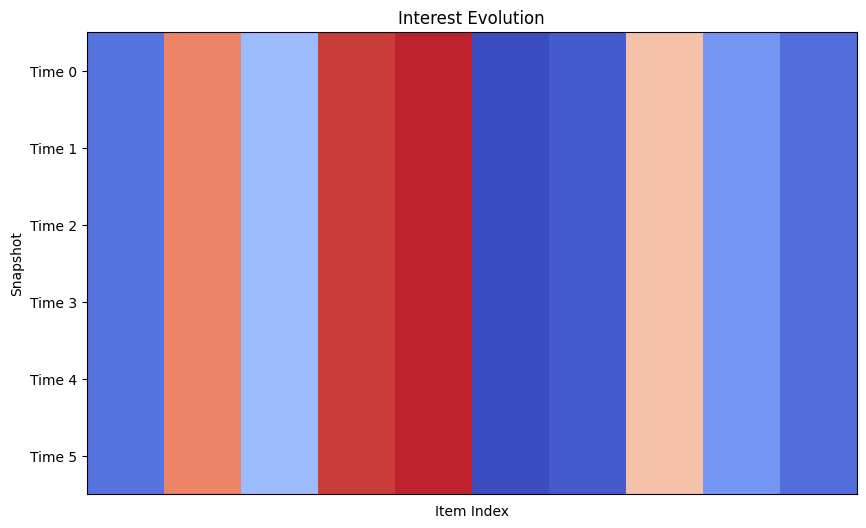

In [75]:
draw_interest_evolution(ratings_map, K = 10)

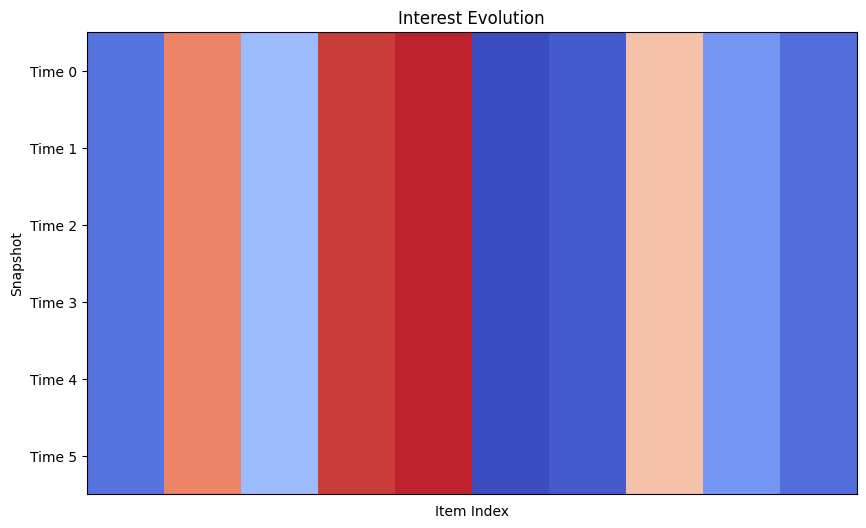

In [76]:
draw_interest_evolution(ratings_map, K = 10)

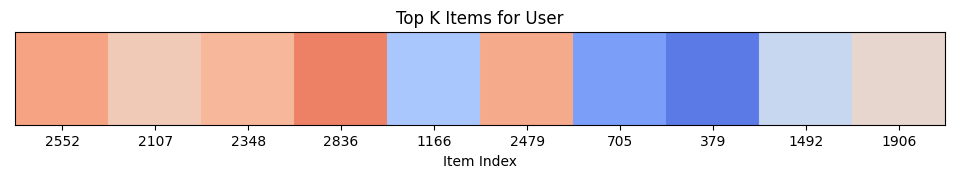

In [77]:


draw_top_items(ratings, K = 10)


In [78]:
d2

array([4.0555544, 4.0839195, 3.7818174, 2.586011 , 4.0839195, 4.0555544],
      dtype=float32)

Коэффициент корреляции Пирсона: 0.13544276482204226
Корреляция Спирмена: -0.12712834523274563


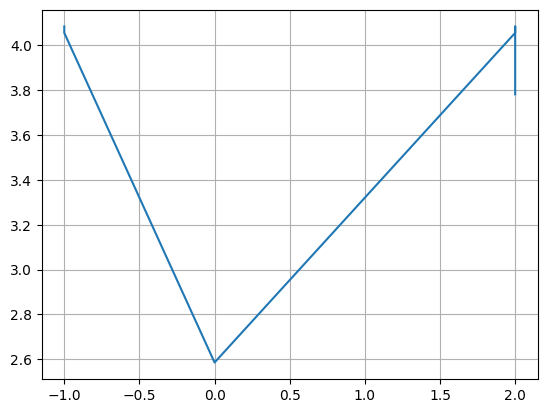

In [79]:
from scipy.stats import pearsonr, spearmanr

# Вычисление коэффициента корреляции Пирсона
pearson_corr, _ = pearsonr(d1[idx], d2[idx])
print(f"Коэффициент корреляции Пирсона: {pearson_corr}")

# Вычисление корреляции Спирмена
spearman_corr, _ = spearmanr(d1[idx], d2[idx])
print(f"Корреляция Спирмена: {spearman_corr}")

plt.plot(d1[idx], d2[idx])
plt.grid()

### Train distribution

[56.0, 1551.0, 1554.0, 2064.0, 830.0, 1544.0, 624.0, 753.0, 22.0, 1060.0, 1077.0, 2478.0, 2024.0, 1272.0, 644.0, 2544.0, 166.0, 1076.0, 1309.0, 2371.0, 861.0, 2408.0, 2114.0, 591.0, 49.0, 2361.0, 1147.0, 794.0, 1229.0, 1617.0, 484.0, 1078.0, 54.0, 2521.0, 1866.0, 11.0, 1526.0, 325.0, 2896.0, 1989.0, 1648.0, 410.0, 369.0, 884.0, 2252.0, 1970.0, 2517.0, 390.0, 2172.0, 2038.0, 718.0, 592.0, 534.0, 2378.0, 353.0, 1594.0, 1837.0, 212.0, 1962.0, 2628.0, 2871.0, 2174.0, 1933.0, 2509.0, 1222.0, 202.0, 1218.0, 1256.0, 2438.0, 2435.0, 1947.0, 2575.0, 559.0, 795.0, 1615.0, 841.0, 1107.0, 595.0, 2209.0, 1767.0]


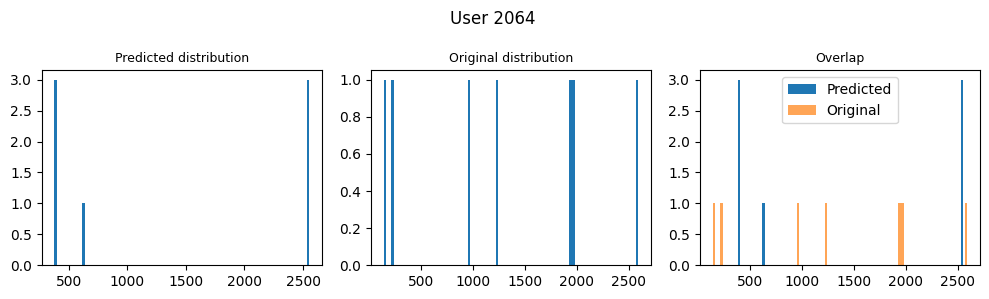

In [34]:
users, users_original = calc_distrib(train_mdp)

keys = list(users.keys())
print(keys)
idx = keys.index(2064)
#print(sorted(keys))
target_key = keys[idx]

plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.hist(users[keys[idx]], bins = 100)
plt.title("Predicted distribution", size = 9)
plt.subplot(1,3,2)
plt.hist(users_original[keys[idx]], bins = 100)
plt.title("Original distribution", size = 9)
plt.subplot(1,3,3)


plt.hist(users[keys[idx]], bins = 100, label = "Predicted")
plt.hist(users_original[keys[idx]], bins = 100, alpha = 0.7, label = "Original")
plt.legend()
plt.title("Overlap", size = 9)

plt.suptitle("User %d "%keys[idx])
plt.tight_layout()


[11.0, 202.0, 369.0, 484.0, 595.0, 794.0, 861.0, 1060.0, 1077.0, 1107.0, 1147.0, 1544.0, 1551.0, 1648.0, 1837.0, 1866.0, 1970.0, 2064.0, 2114.0, 2172.0, 2209.0, 2438.0, 2509.0, 2544.0, 2628.0]


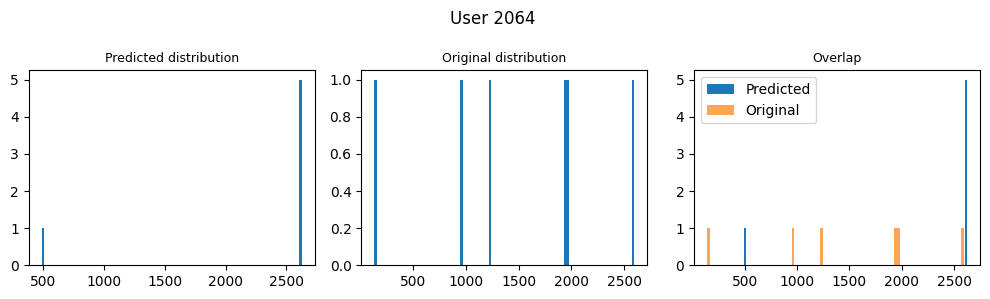

In [52]:
users, users_original = calc_distrib(test_mdp)

keys = list(users.keys())
print(sorted(keys))
idx = keys.index(target_key)


plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
plt.hist(users[keys[idx]], bins = 100)
plt.title("Predicted distribution", size = 9)
plt.subplot(1,3,2)
plt.hist(users_original[keys[idx]], bins = 100)
plt.title("Original distribution", size = 9)
plt.subplot(1,3,3)


plt.hist(users[keys[idx]], bins = 100, label = "Predicted")
plt.hist(users_original[keys[idx]], bins = 100, alpha = 0.7, label = "Original")
plt.legend()
plt.title("Overlap", size = 9)

plt.suptitle("User %d "%keys[idx])
plt.tight_layout()

### Test distribution

/home/babycar/RecSysMDP/recsys_mdp/mdp_former/episode_split_fucntions.py:12: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  ts = pd.to_datetime(user_log[ts_name]).astype(int) // 10 ** 9


Count of episodes:  25
Mean of episodes:  9.08
Median of episodes:  9.0


Text(0.5, 1.0, 'SberZvuk-clickstream_1ku.csv \n episodes_count = 25')

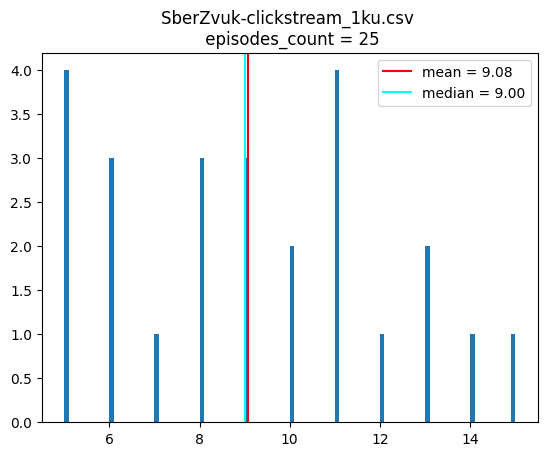

In [30]:
test_data, _, test_values = load_data(data_path=config['experiment']['test_data_path'],
                                          return_values=True,
                                          col_mapping=config['experiment']['col_mapping'])

config['experiment']['mdp_settings']['episode_splitter_name'] = "interaction_interruption"
test_mdp_preparator = make_mdp(data=test_data, data_mapping=data_mapping, **config['experiment']['mdp_settings'])
states, rewards, actions, termations, _ = test_mdp_preparator.create_mdp()
test_mdp = to_d3rlpy_form_ND(states, rewards, actions, termations, discrete=prediction_type)

episodes_len = []
for state in states:
    episodes_len.append(len(state))
    
print("Count of episodes: ", len(states))
print("Mean of episodes: ", np.mean(episodes_len))
print("Median of episodes: ", np.median(episodes_len))

plt.hist(episodes_len, bins = 100);
plt.axvline(x=np.mean(episodes_len), color='red', label="mean = %.2f"%(np.mean(episodes_len)))
plt.axvline(x=np.median(episodes_len), color='cyan', label="median = %.2f"%np.median(episodes_len))
plt.legend()

plt.title("SberZvuk-clickstream_1ku.csv \n episodes_count = %d"%len(states))
#plt.grid()